## General purpouse analysis functions

In [110]:
import numpy as np
import math
import matplotlib.pyplot as plt
import csv
import os
from scipy.signal import butter, filtfilt

############################################ Functions ############################################

def csv2array(file_name, folder_name, column_x_index, column_y_index, starting_row, Delimiter):
    """
    Read a CSV file stored on a subfolder and extract data from two columns.

    @param file_name: The name for the CSV file.
    @param column_x_index: The index of the first column to extract, A=0, B=1....
    @param column_y_index: The index of the second column to extract.
    @param starting_row: The row index to start reading data from, row=1, 2...
    @param Delimiter: Separator between columns

    @return: A list containing two arrays with values extracted from the specified columns, these arrays column x and column y in that order. It also contains the name of the file

    @note:Expected folder structure

    folder/
    ├── notebook.ipynb
    └── subfolder/
        ├── file1.csv
        ├── file2.csv
        └── file3.csv


    @Warning: If you copy the string from the browser and dont want to change backslash for '/' read it as raw by writing an 'r' before the string path like so: 'csv2array(r"C:...'



    """
    
    # Arrays to store x and y values, in that order
    column_x_values = []
    column_y_values = []

    # Fix row indexing
    starting_row = starting_row - 1

    # Dynamicaly read the path to the file
    #folder_path = os.path.dirname(os.path.abspath("Analisis_Figuras_Paper.ipynb"))
    folder_path = os.getcwd()
    CSV_PATH = os.path.join(folder_path, folder_name, file_name)


    # Read the CSV file. 'with' statement handles closing the file correctly without using 'close'.
    with open(CSV_PATH, 'r') as file:
        reader = csv.reader(file, delimiter = Delimiter)
        
        # Skip rows until the starting row
        for _ in range(starting_row):

            # next runs through an iterable
            next(reader)
        
        # Read rows until an empty cell is encountered
        for row in reader:
            if not row[column_x_index] or not row[column_y_index]:
                break  # Stop reading if either column has an empty cell
            
            # Values are read as strings, change commas for dots before casting to floats
            value_x = row[column_x_index].replace(',', '.')
            value_y = row[column_y_index].replace(',', '.')

            # Cast to floats
            column_x_values.append(float(value_x))
            column_y_values.append(float(value_y))

    # Also return a string containing the name of the data
    file_name = os.path.basename(CSV_PATH)
    file_name = os.path.splitext(file_name)[0]

    
    # Return the lists as arrays
    return [np.array(column_x_values), np.array(column_y_values), file_name]



def filter_data(order, cutoff_freq, data, Btype='low', graph=True):
    """
    Read a 2D array, design a butterworth filter, apply it and visualize it.

    This function is meant to be used in succession to csv2array, it applies a filter without delay and graphs the raw signals spectrum as well as the filtered one.
    This is done to aid in the design of the filter.

    @param order: order of the filter, since the filter is applied twice to achieve zero phase shift this is actualy half of the final order.
    @param cutoff_freq: cutoff frequency in Hz for the filter
    @param data: a list containing 2 arrays like so: [x, y]
    @param Btype: Type of filter for scipy's butter function
    @param graph: Boolean to decide wether to graph the results or not

    @return: a list containing two arrays with values extracted from the specified columns, these arrays column x and column y in that order. It also contains the name of the file

    @Warning: Samples should be evenly spaced in time.
    """

    x_raw = data[0]
    y_raw = data[1]


    ################# Design Filter #########################################################################
    # Sampling frequency in Hz
    sampling_freq = 1 / (x_raw[1] - x_raw[0])

    # Convert cutoff frequency to a normalized value
    nyquist_freq = 0.5 * sampling_freq
    normalized_cutoff = cutoff_freq / nyquist_freq

    # Design a Butterworth filter
    b, a = butter(order, normalized_cutoff, btype=Btype, analog=False, output='ba')

    # Apply the filter using filtfilt to achieve zero-phase filtering
    y_filt = filtfilt(b, a, y_raw)


    ################# FFT #################################################################################
    # Compute the FFT of both the raw and filtered signals
    y_fft_raw = np.fft.fft(y_raw)
    y_fft_filt = np.fft.fft(y_filt)

    # Compute frequency array, same length and with sampling interval d=Delta x
    freq = np.fft.fftfreq(len(y_raw), d=(x_raw[1] - x_raw[0]))

    # Find the indices corresponding to the desired frequency range (0 to 1.0)
    freq_indices = np.where(np.logical_and(freq >= 0, freq <= 1000))



    ################# Plot ################################################################################
    # Clear the existing subplot and plot the FFT
    if (graph):
        # Create a figure with two subplots
        fig, axs = plt.subplots(2, 1)
        ax = axs[0]
        ax.clear()
        ax.plot(freq[freq_indices], np.abs(y_fft_raw[freq_indices]), linewidth=0.5, alpha=0.25, color="black")
        ax.plot(freq[freq_indices], np.abs(y_fft_filt[freq_indices]), linewidth=0.5, color="blue")
        ax.set_ylabel('Amplitude')
        ax.set_title('FFT of '+str(data[2]))
        ax.set_xlabel('Frequency [Hz]')

        # Plot raw vs filtered data
        ax = axs[1]
        ax.scatter(x_raw, y_raw, s=1, alpha=1, color="k")
        ax.plot(x_raw, y_filt, color="blue", linewidth=1)

        # Adjust the spacing between subplots
        plt.subplots_adjust(hspace=0.6)

        plt.show()

    return [x_raw, y_filt, data[2]]


### Read CSV data

In [111]:
BICPDMS000ROI = csv2array(file_name="BICPDMS000ROI.csv", folder_name="Data", column_x_index=0, column_y_index=1, starting_row=2, Delimiter=';')
BicStrycSf501 = csv2array(file_name="BicStrycSf501.csv", folder_name="Data", column_x_index=0, column_y_index=1, starting_row=2, Delimiter=';')

# Append to each list of data their corresponding units
BicStrycSf501.append(r'$\mu_{0} H$ [nT]')
BICPDMS000ROI.append(r'$Ca^{2+}$ [a.u.]')

# Store into one array for iterations
Data = [(BicStrycSf501), (BICPDMS000ROI)]


## Filter Data

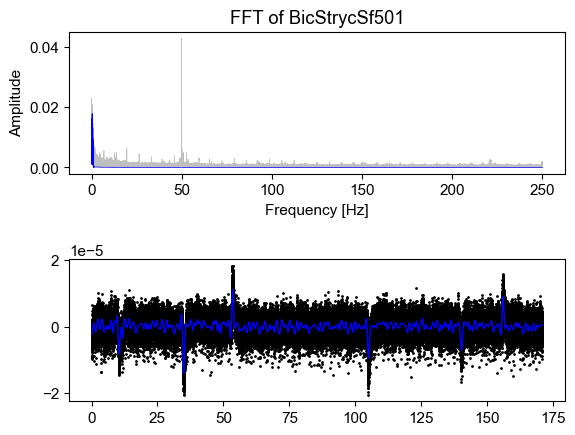

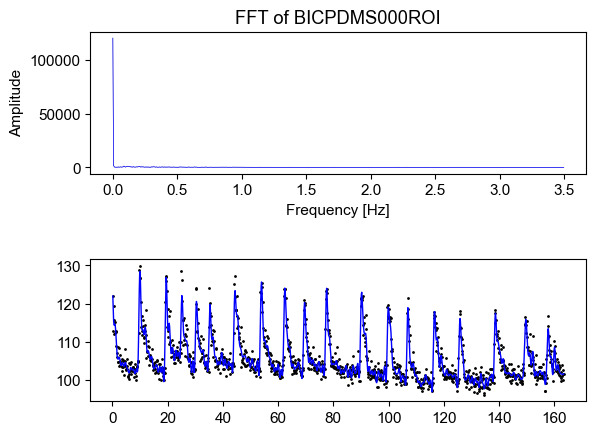

In [85]:
for data in Data:
    filter_data(order=7, cutoff_freq=1, data=data, Btype='low', graph=True)

### Bandpass example

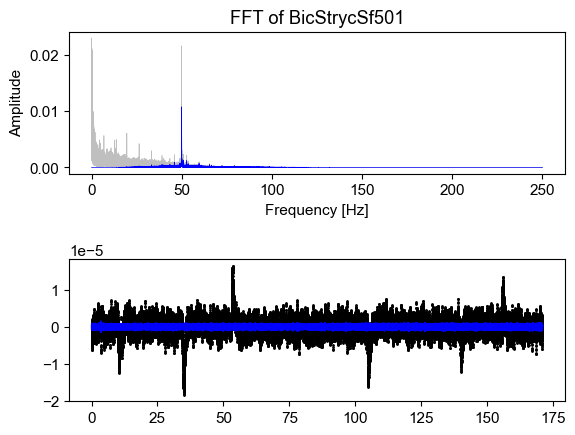

In [102]:
# Make first iteration "non-verbose"
data_LP_filt = filter_data(order=2, cutoff_freq=50, data=Data[0], Btype='low', graph=False)
data_BP_filt = filter_data(order=2, cutoff_freq=50, data=data_LP_filt, Btype='high')

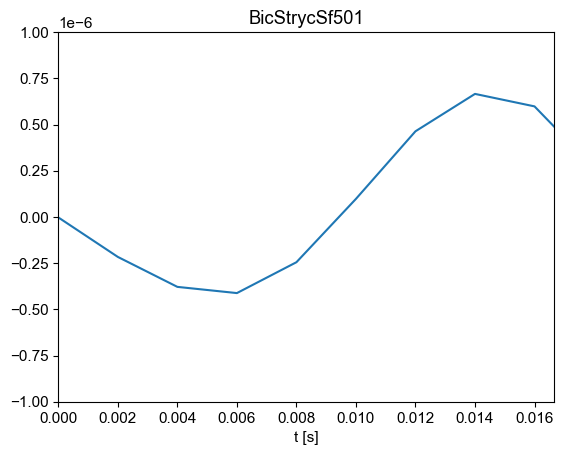

In [103]:
# Create a new figure
fig = plt.figure()

# Add a subplot
ax = fig.add_subplot(111)

# Plot the data
ax.plot(data_BP_filt[0], data_BP_filt[1])

# Customize the plot
ax.set_xlabel('t [s]')
#ax.set_ylabel('')
ax.set_title(data_BP_filt[2])
ax.set_xlim(0, 1/60)
ax.set_ylim(-1E-6, 1E-6)

# Display the figure
plt.show()